In [1]:
## based on https://dynetworkx.readthedocs.io/en/latest/tutorial.html
import dynetworkx as dnx
import networkx as nx

import numpy as np
from numpy.random import PCG64
# use matplotlib to visualize graph?
# see https://www.geeksforgeeks.org/python-visualize-graphs-generated-in-networkx-using-matplotlib/
%matplotlib notebook        
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # plot in 3D

######## IMPORT MY OWN MODULES ########
from trajectory import *          # import the simulator loop 

In [2]:
### environment constants
x_lim    = [0.2, 0.9]
y_lim    = [0., 10.]
z_lim    = [0., 2.7]

# for the fruit distribution, want to keep it the same for these tests
x_seed = PCG64(37428395352013185889194479428694397783)
y_seed = PCG64(13250124924871709375127216220749555998)
z_seed = PCG64(165440185943501291848242755689690423219)

# density of "fruit" in the orchard
density = 10


### robot constants
n_arm  = 3   # K in melon paper
n_cell = 1   # keeping it simple for now

# vehicle speed
v = 0.05   # in m/s 

# 'fruit handling time window,' a constant worst case value (for now)
Tw_con = 5.     # in sec

# cell width/height (perpendicular to movement) and length (parallel to movement)
cell_h = z_lim[1] - z_lim[0]  # w in paper
cell_l = 0.3                  # length of cell

# arm starting locations
arm_location = np.zeros([n_arm, 3])
offset       = 0.2

arm_location[:,0] = 0. # x-coordinate start
arm_location[:,2] = 0. # z-coordinate start

for k in range(n_arm):
    # set the arms at their respective starting y-coord locations based on offset
    arm_location[k,1] = k*offset # y-coordinate start -> assumes #0 is at the back, rest of code doesn't
    
# print(arm_location)

In [3]:
## Interval graph node setup
class fruitNode:
    def __init__(self, i, j, k, t): 
        # ith fruit
        self.i  = i
        # jth fruit picked by this arm
        self.j  = j
        # arm for which edges are being calculated
        self.k  = k
        # jth fruit i that the arm k has picked up, denoted t^{k}_{i(j)}, previous fruit 
        # would be t^{k}_{i(j-1)}
        # time at which kth arm reaches the jth fruit it has picked up
        self.t  = t 

In [4]:
## Functions
def calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z):
    '''
       Calculate Tm (moving time -> move in y,z to next fruit) for node i for arm k.
    '''
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate move in y-axis
    traj_calc.adjInit(start_y, 0.) # start moving from zero speed
    traj_calc.noJerkProfile(traj_calc.q0, fruit_y, traj_calc.v0, v_max, a_max, d_max)
    
    t_y = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(start_z, 0.) 
    traj_calc.noJerkProfile(traj_calc.q0, fruit_z, traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate which will dominate
    Tm = max(t_y, t_z)
    
    return(Tm)


def calcTd(traj_calc, fruit_x, fruit_z):
    '''
       Calculate handling time -> extension + pick time + retraction + conveyor drop off 
       for node i. Seperated into two values, before picking (Td0) and after picking (Td1) 
    '''
    # constants
    t_grab = 0.1 
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate extension (retraction)
    traj_calc.adjInit(0., 0.)      # starts at zero for x each time (extend to fruit)
    traj_calc.noJerkProfile(traj_calc.q0, fruit_x, traj_calc.v0, v_max, a_max, d_max)
    
    t_x = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(fruit_z, 0.) # starts at fruit's location (move to conveyor from fruit)
    traj_calc.noJerkProfile(traj_calc.q0, 0., traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # add them together to get before picking and after picking
    Td0 = t_grab + t_x
    Td1 = t_x + t_z
    
    return([Td0, Td1])


def intervalGraph(k, ystart, ystop, color='b'):
    '''Interval graph of the edges with given k arm and color.''' 
    # plot the interval
    plt.hlines(k, ystart, ystop, color, lw=4)
    # plots the whiskers/ends
    plt.vlines(ystart, k+0.03, k-0.03, color, lw=2)
    plt.vlines(ystop, k+0.03, k-0.03, color, lw=2)


In [5]:
## Create fruit data set
len_x = x_lim[1] - x_lim[0]            
len_y = y_lim[1] - y_lim[0]  
len_z = z_lim[1] - z_lim[0]

numFruit = int(density * (len_y*len_x*len_z))  

x = np.random.default_rng(x_seed).uniform(x_lim[0], x_lim[1], numFruit)
y = np.random.default_rng(y_seed).uniform(y_lim[0], y_lim[1], numFruit)
z = np.random.default_rng(z_seed).uniform(z_lim[0], z_lim[1], numFruit)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x, y, z])

axis_to_sort = np.argsort(y) # sort based on y-axis
sortedFruit = fruit[:,axis_to_sort]

# create an array (or list if it'll need to be dynamic later) for node objects
node_array  = np.ndarray(numFruit+n_arm, dtype=object)  # numFruit+arm_node for the initial dummy nodes for each arm

In [6]:
## Initialize the interval graph
IG = dnx.IntervalGraph()

# arm settings, also in calcTd function
v_max = 0.8
a_max = 3.1
d_max = a_max

## initialize the ability to calculate trajectory
traj_calc = Trajectory(v_max, a_max, d_max)

In [7]:
## (a) initialize dummy 0 nodes for each arm k
for k in range(n_arm): 
    node_array[k] = fruitNode(0, 0, k, 0)
    IG.add_node(node_array[k])
    
# IG.nodes(data=True) # show the attributes for each node (maybe not necessary)
print('did the dummy node for k=1 get created?', IG.has_node(node_array[1]))
print('k value for dummy node for k=1 (should be = 1):', node_array[1].k)

for i in range(numFruit):
    node_array[i+3] = fruitNode(i, 0, n_arm, 0) # k = n_arm which is > n-1 (index) to identify unpicked fruit
    IG.add_node(node_array[i+3])
    
print('number of fruit:', numFruit)    
print('number of nodes after adding all fruit:', len(IG.nodes()))

did the dummy node for k=1 get created? True
k value for dummy node for k=1 (should be = 1): 1
number of fruit: 189
number of nodes after adding all fruit: 192


In [8]:
'''What if we just use time intervals...'''

edge_list = list()
k_edges   = list()
Tw_values = list()

# calculate the time intervals describing when the arm would be busy picking each fruit (n_arm * numFruit)
for index, y_i in enumerate(sortedFruit[1]):
    # calculate y_i / v which is constant for this fruit
    
    # handling time will not be constant here
    [Tw0, Tw1] = calcTd(traj_calc, sortedFruit[0, index], sortedFruit[2, index])
    Tw_values.append([Tw0, Tw1]) # save values since it will be used to calc picking time later
    
    Tw = Tw0 + Tw1
    
    # values of fruit location at the start and end, as well as the handling time
    t_start_0 = y_i / v - Tw # adding the calculated handling time 
    t_end_0   = y_i / v      # the end time will be when the back frame is reached by the fruit 
    
    k_edges.append(index)
    
    for k in range(n_arm):
        # add the offset based on the arm number (assuming back arm is k=0 to front arm k=n_arm)
#         offset = (cell_l*(k+1)) / v  # (k+1) to indicate it's the front frame location we're looking for
        offset = (cell_l*k) / v  # looking at the back part of the frame 
        
        ## Saying here that the fruit can only be picked if arm is not busy when the front of the frame reaches t
        #  the fruit
        
        t_start_k = t_start_0 - offset
        t_end_k   = t_end_0 - offset
        
        ### NOTE: check if interval too long versus the amount of time fruit is in cell (t = cell_l/v)      
        if t_start_k > 0 and t_end_k > 0 and t_end_k - (t_start_k + Tw0) < cell_l/v:
            # the interval has to be positive or it cannot be used (impossible to pick that fruit)
            k_edges.append([k, t_start_k, t_end_k])
            
    
    if len(k_edges) > 1:
#         print(k_edges)
        edge_list.append(k_edges.copy()) # if not a copy, values in edge_list also get deleted in next line
    
    # delete values in k_edges
    del k_edges[:]
    
print(edge_list)

[[5, [0, 1.985285077545516, 5.388858477172875]], [6, [0, 1.1802586326810287, 5.617199680475715]], [7, [0, 3.2775498804436047, 8.001688959815167]], [8, [0, 4.860500843420944, 8.797904172040516]], [9, [0, 5.1095626130584915, 9.075223611400206]], [10, [0, 6.1176664047416125, 10.237202009136626], [1, 0.11766640474161338, 4.2372020091366265]], [11, [0, 9.50430407611479, 11.69834119060289], [1, 3.5043040761147912, 5.69834119060289]], [12, [0, 7.42609204520175, 12.175490595940941], [1, 1.4260920452017505, 6.175490595940942]], [13, [0, 7.479039992864564, 12.964418418899593], [1, 1.479039992864565, 6.9644184188995935]], [14, [0, 12.117869998454466, 15.586870665480012], [1, 6.117869998454467, 9.586870665480014], [2, 0.11786999845446822, 3.5868706654800135]], [15, [0, 13.408877541249915, 17.453463401308753], [1, 7.4088775412499155, 11.453463401308753], [2, 1.4088775412499164, 5.453463401308754]], [16, [0, 12.70370086110072, 18.065141873905798], [1, 6.70370086110072, 12.065141873905798], [2, 0.703

In [9]:
'''now have to figure out which arm picks what based on time intervals'''
## ASSUMES: arm ready to pick instantly after finishing picking last fruit (no movement time needed)


# (b) process nodes in order of increasing y-coord
# Td = np.zeros(n_arm)
t  = np.zeros([n_arm, numFruit+1]) # t of arm k when *finished picking* (Tm+Td) fruit i

# update this for when there are more than three arms
last_i = np.array([node_array[0], node_array[1], node_array[2]]) # saves the fruit id of the fruit last picked by the arm k 
curr_j = np.array([node_array[0].j, node_array[1].j, node_array[2].j]) # saves the number of fruit being picked by 
# the kth arm

for e in edge_list:
    i   = e[0] ## causes below k+1 because e[0] is i (fruit num)
    
    for k in range(len(e)-1):
        # the arm number (changes based on how many intervals had negative values) 
        # => not all arms could pick fruit
#         print('arm number', k)
#         print('start:', e[k+1][1], 'end:', e[k+1][2]) 
        
        # take the previously chosen i for arm k and add in the move time to new i
        prev = sortedFruit[1, last_i[k].i] 
        # calculate how far the vehicle moves between the interval end of y_(i-1) and interval start of y_i
        # also removes the Td/Tw after picking value (won't move in y after that)
        veh_move = (e[k+1][1] - (last_i[k].t - Tw_values[i][1]))*v  
        
        # move to new location arrived when moving to get the next fruit
        # ends in line with previous fruit plus the distance the vehicle moves between the end time of last fruit
        # and the beginning time of this one
        start_y = prev + veh_move      
        start_z = 0.                          # ends at the bottom to drop off the fruit
        
        print('y_(i-1):', prev, 'y_i:', sortedFruit[1,i])
        print('new y(i-1):', start_y, 'since vehicle moves:', veh_move)
        
        # new fruit's location
        fruit_y = sortedFruit[1,i]
        fruit_z = sortedFruit[2,i]
        
        # calculate how long it would take to reach new fruit
        Tm = calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z)
        
        start_time = e[k+1][1] - Tm # add movement into work before handling to get the true total time interval
        
        # careful with reference, the return should actually be ((u,v), begin, end)
        # https://dynetworkx.readthedocs.io/en/latest/reference/classes/generated/dynetworkx.IntervalGraph.edges.html#dynetworkx.IntervalGraph.edges
#         n_interval = IG.edges(begin=e[k+1][1], end=e[k+1][2]) # check if there are edges that lie between the new edges?
#         print('number of intervals that fall within the current calculated edges',len(n_interval))

#         is_busy    = IG.edges(v=last_i[k], begin=e[k+1][1], end=e[k+1][2])
#         print('is arm', k, 'already busy for this interval?', len(is_busy))
        
        
        n_interval = IG.edges(begin=start_time, end=e[k+1][2]) # check if there are edges that lie between the new edges?
        print('number of intervals that fall within the current calculated edges',len(n_interval))

        is_busy    = IG.edges(v=last_i[k], begin=start_time, end=e[k+1][2])
        print('is arm', k, 'already busy for this interval?', len(is_busy))
        
        if k > 0:
            # the arm's cell_l depends on the previous arm's location => at this point it's not really the cell_l
            # does the next arm forward's position matter at all? => should have been solved by calculating e's?
#             last_arm_edge = IG.edges(v=last_i[k-1], begin=start_time, end=e[k+1][2])
#             last_arm_edge = IG.edges(begin=start_time, end=e[k+1][2])
            
#             if last_arm_edge:
            if n_interval:
                # check if there are values inside this list (info on arm location)
#                 print('previous arm edge (to get end location)',last_arm_edge[-1])
                # get the index of the fruit keeping k-1 busy
#                 busy_index = last_arm_edge[-1][1].i
                busy_index = n_interval[-1][1].i
                
                # find y_{(k-1),t} where t = e[k+1][2] (end time of this interval)
#                 end_last_arm = last_arm_edge[-1][3] - Tw_values[busy_index][1] # end time for arm k-1 when fruit 
                end_last_arm = n_interval[-1][3] - Tw_values[busy_index][1] # pick time for arm k-1 of fruit i (not the end of PCT)
                
                print('original end time', cell_l*(k-1)/v, 'end time based on arm {k-1}', end_last_arm)
                # get the difference between lk (already calculated) and y_{(k-1),t} to find new offset
                delta_T = (cell_l*(k-1) / v) - end_last_arm
                print('difference in time:', delta_T)
            
#             else:
                # if no info, nothing changes and we use lk as the value 
            

        if len(n_interval) < n_arm and len(is_busy) < 1: 
            # add an edge between the last node and this node with interval edge U
            print('      add edge')
#             IG.add_edge(last_i[k], node_array[i+n_arm], e[k+1][1], e[k+1][2])
            IG.add_edge(last_i[k], node_array[i+n_arm], start_time, e[k+1][2])

            # update the node
            node_array[i+n_arm].j = curr_j[k] + 1
            node_array[i+n_arm].k = k
            node_array[i+n_arm].t = e[k+1][2]   

            # update all the saved prev node data
            last_i[k] = node_array[i+n_arm]
            curr_j[k] = node_array[i+n_arm].j # maybe don't need to save this array, just use last_i

            # skip this fruit for the rest of the arms
            print()
            break

y_(i-1): 0.005292470942258598 y_i: 0.26944292385864377
new y(i-1): 0.22667928149802777 since vehicle moves: 0.22138681055576917
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 0.26944292385864377 y_i: 0.28085998402378576
new y(i-1): 0.20894012583345054 since vehicle moves: -0.06050279802519323
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 0.26944292385864377 y_i: 0.4000844479907584
new y(i-1): 0.3492520879467032 since vehicle moves: 0.07980916408805944
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 0.26944292385864377 y_i: 0.4398952086020258
new y(i-1): 0.4094588977247502 since vehicle moves: 0.14001597386610642
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 0.26944292385864377 y_i: 

is arm 2 already busy for this interval? 0
original end time 5.999999999999999 end time based on arm {k-1} 68.55064780863701
difference in time: -62.55064780863701
y_(i-1): 3.9605885730512247 y_i: 4.03218388870652
new y(i-1): 3.971837138878697 since vehicle moves: 0.011248565827472135
number of intervals that fall within the current calculated edges 2
is arm 0 already busy for this interval? 1
y_(i-1): 3.816213370957595 y_i: 4.03218388870652
new y(i-1): 3.971837138878697 since vehicle moves: 0.15562376792110158
number of intervals that fall within the current calculated edges 3
is arm 1 already busy for this interval? 1
original end time 0.0 end time based on arm {k-1} 73.1033821252019
difference in time: -73.1033821252019
y_(i-1): 2.2118843718775603 y_i: 4.03218388870652
new y(i-1): 3.971837138878697 since vehicle moves: 1.7599527670011363
number of intervals that fall within the current calculated edges 4
is arm 2 already busy for this interval? 0
original end time 5.999999999999999 

is arm 1 already busy for this interval? 1
original end time 0.0 end time based on arm {k-1} 135.289280514369
difference in time: -135.289280514369
y_(i-1): 7.048395322042213 y_i: 7.117534193927951
new y(i-1): 7.058387828410794 since vehicle moves: 0.009992506368581644
number of intervals that fall within the current calculated edges 4
is arm 2 already busy for this interval? 1
original end time 5.999999999999999 end time based on arm {k-1} 130.44983663339403
difference in time: -124.44983663339403
y_(i-1): 6.888897859587681 y_i: 7.1331585790362535
new y(i-1): 7.078211124582333 since vehicle moves: 0.18931326499465229
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 6.906962018043751 y_i: 7.1331585790362535
new y(i-1): 7.078211124582333 since vehicle moves: 0.17124910653858194
number of intervals that fall within the current calculated edges 4
is arm 1 already busy for this interval? 1
original end time 0.0 end time

new y(i-1): 9.804557486843152 since vehicle moves: 1.060975333187686
number of intervals that fall within the current calculated edges 4
is arm 2 already busy for this interval? 0
original end time 5.999999999999999 end time based on arm {k-1} 183.50420527887115
difference in time: -177.50420527887115
y_(i-1): 9.594381216202791 y_i: 9.941997379753284
new y(i-1): 9.886085582818772 since vehicle moves: 0.2917043666159813
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 9.599136682884568 y_i: 9.941997379753284
new y(i-1): 9.886085582818774 since vehicle moves: 0.2869488999342053
number of intervals that fall within the current calculated edges 3
is arm 1 already busy for this interval? 1
original end time 0.0 end time based on arm {k-1} 189.70290568797435
difference in time: -189.70290568797435
y_(i-1): 8.743582153655465 y_i: 9.941997379753284
new y(i-1): 9.886085582818774 since vehicle moves: 1.1425034291633083
number

In [10]:
print('Total number of fruit:', numFruit)
print('Total harvested fruit:', np.sum(curr_j), 'or', np.sum(curr_j)/numFruit, '%')
print('Number of fruit picked by arm 0:', curr_j[0], 'arm 1:', curr_j[1], 'arm 2:', curr_j[2])

Total number of fruit: 189
Total harvested fruit: 71 or 0.37566137566137564 %
Number of fruit picked by arm 0: 32 arm 1: 29 arm 2: 10


In [11]:
IG.edges()

fruit_picked_by = list()
for k in range(n_arm+1):
    fruit_picked_by.append([])

for i in range(n_arm, numFruit+n_arm):
    fruit_picked_by[node_array[i].k].append(node_array[i].i)

print(fruit_picked_by)

[[5, 11, 15, 21, 24, 27, 31, 36, 43, 47, 57, 64, 69, 73, 84, 87, 95, 96, 104, 107, 113, 117, 123, 128, 136, 145, 149, 154, 159, 167, 172, 175], [10, 14, 19, 23, 28, 33, 40, 45, 54, 60, 66, 71, 77, 86, 92, 99, 106, 108, 115, 121, 129, 137, 146, 150, 156, 160, 169, 173, 176], [25, 29, 37, 78, 89, 101, 111, 130, 148, 164], [0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 16, 17, 18, 20, 22, 26, 30, 32, 34, 35, 38, 39, 41, 42, 44, 46, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 61, 62, 63, 65, 67, 68, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 88, 90, 91, 93, 94, 97, 98, 100, 102, 103, 105, 109, 110, 112, 114, 116, 118, 119, 120, 122, 124, 125, 126, 127, 131, 132, 133, 134, 135, 138, 139, 140, 141, 142, 143, 144, 147, 151, 152, 153, 155, 157, 158, 161, 162, 163, 165, 166, 168, 170, 171, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]]


<IPython.core.display.Javascript object>


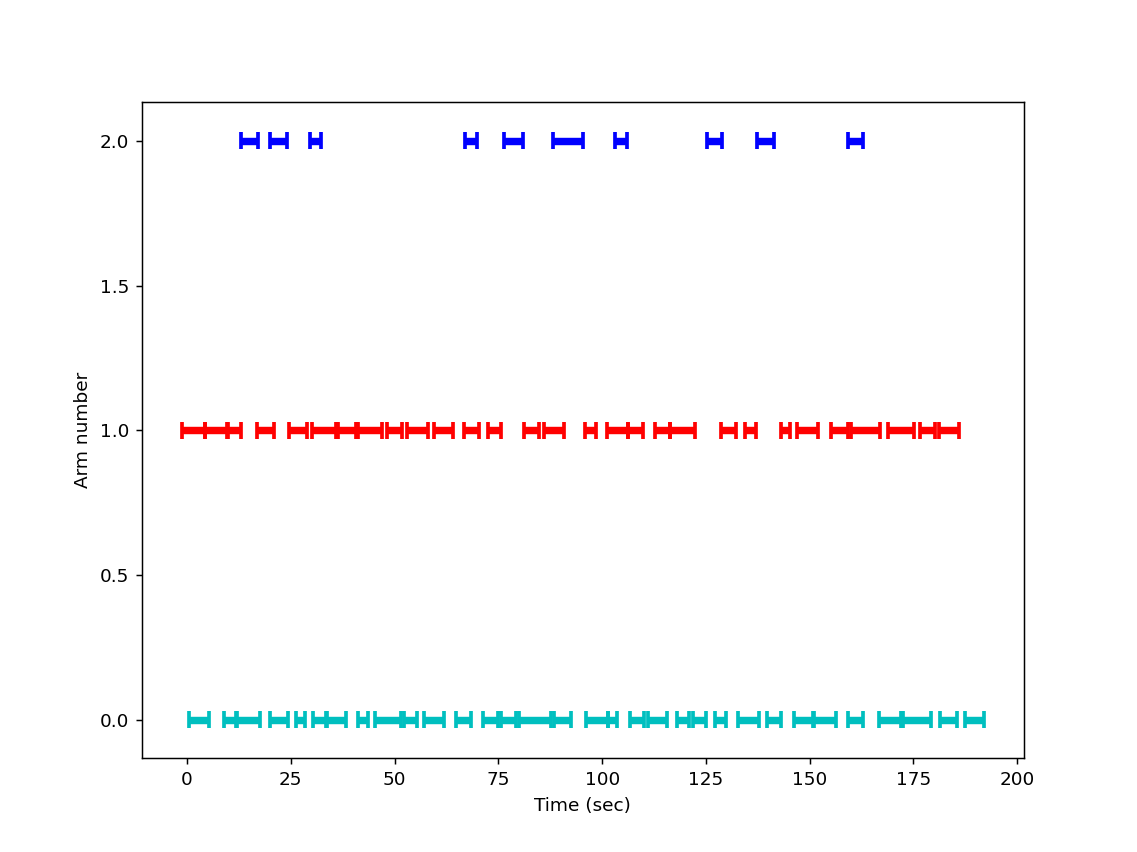

In [12]:
'''Plot the intervals -- Testing time not distance intervals'''
# based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# plot is based on time...
fig, ax = plt.subplots()

for e in IG.edges():
    if e[1].k == 0:
        intervalGraph(e[1].k, e[2], e[3], color='c')
    elif e[1].k == 1:
        intervalGraph(e[1].k, e[2], e[3], color='r')
    elif e[1].k == 2:
        intervalGraph(e[1].k, e[2], e[3], color='b')

plt.xlabel('Time (sec)')
plt.ylabel('Arm number')
        
plt.show()

<IPython.core.display.Javascript object>


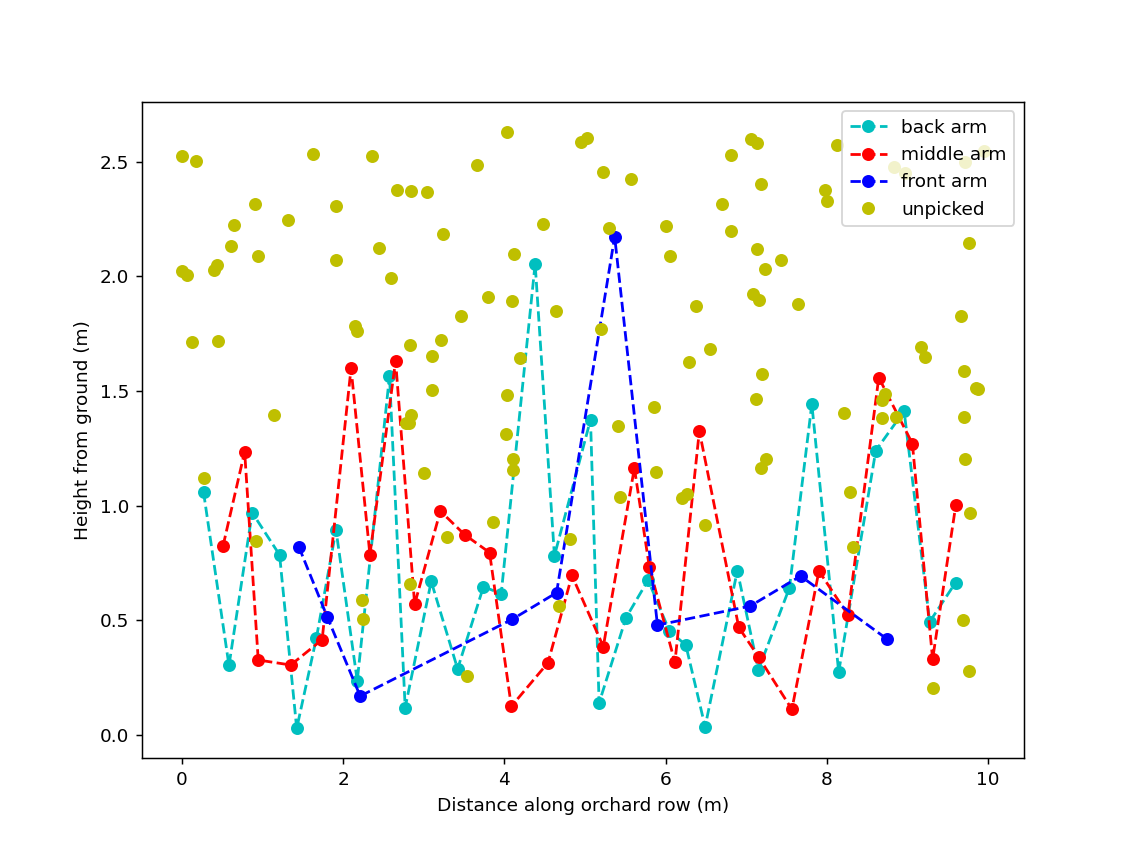

In [13]:
fig, ax = plt.subplots()

plt.plot(sortedFruit[1][fruit_picked_by[0]], 
         sortedFruit[2][fruit_picked_by[0]], 'o--c', label='back arm')

plt.plot(sortedFruit[1][fruit_picked_by[1]], 
         sortedFruit[2][fruit_picked_by[1]], 'o--r',  label='middle arm')

plt.plot(sortedFruit[1][fruit_picked_by[2]], 
         sortedFruit[2][fruit_picked_by[2]], 'o--b',  label='front arm')

plt.plot(sortedFruit[1][fruit_picked_by[3]], 
         sortedFruit[2][fruit_picked_by[3]], 'oy',  label='unpicked')

plt.xlabel('Distance along orchard row (m)')
plt.ylabel('Height from ground (m)')

legend = ax.legend(loc='upper right')
                   
plt.show()

<IPython.core.display.Javascript object>


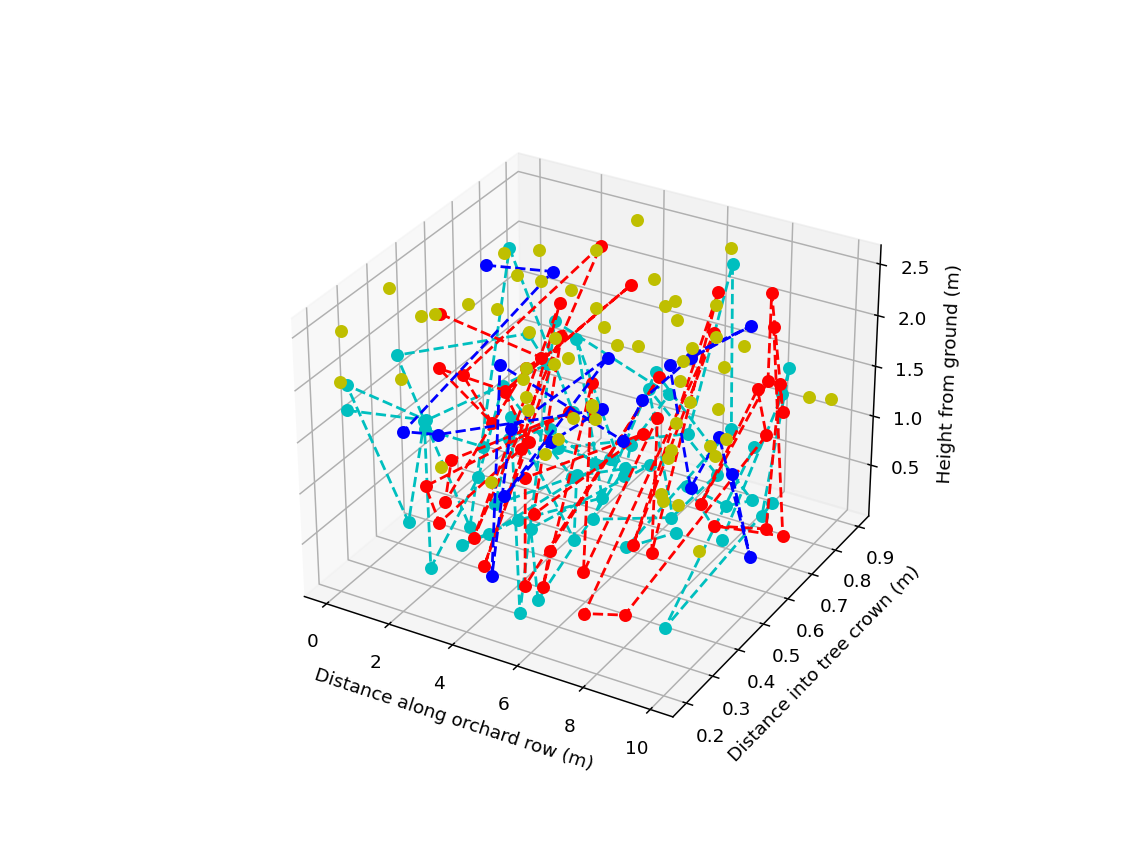

In [14]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

plt.plot(sortedFruit[1][fruit_picked_by[0]], sortedFruit[0][fruit_picked_by[0]], sortedFruit[2][fruit_picked_by[0]], 'o--c')
plt.plot(sortedFruit[1][fruit_picked_by[1]], sortedFruit[0][fruit_picked_by[1]], sortedFruit[2][fruit_picked_by[1]], 'o--r')
plt.plot(sortedFruit[1][fruit_picked_by[2]], sortedFruit[0][fruit_picked_by[2]], sortedFruit[2][fruit_picked_by[2]], 'o--b')
plt.plot(sortedFruit[1][fruit_picked_by[3]], sortedFruit[0][fruit_picked_by[3]], sortedFruit[2][fruit_picked_by[3]], 'oy')


ax.set_xlabel('Distance along orchard row (m)')
ax.set_ylabel('Distance into tree crown (m)')
ax.set_zlabel('Height from ground (m)')

plt.show()